## Import packages

In [1]:
import os
from collections import OrderedDict as ordict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns                                # $:~ conda install seaborn
import scipy.stats as stats
import scipy.optimize as opt

%matplotlib inline

## Style settings

In [16]:
sns.set_style('white')
sns.set_context('paper')
sns.set_palette(sns.dark_palette('blue'))

matplotlib.rcParams['xtick.labelsize'] = 30 # 30 = 14 (abstract = poster)
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['axes.labelsize'] = 35 # 35 = 16
matplotlib.rcParams['legend.fontsize'] = 30
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.default'] = 'rm'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

greens = sns.cubehelix_palette(n_colors=5, start=2.0, rot=.2, gamma=1, hue=.8, light=.8, dark=.15)
reds = sns.cubehelix_palette(n_colors=3, start=0.8, rot=.1, gamma=.7, hue=2, light=.7, dark=.15)

sns.set_palette(greens)

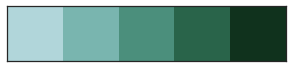

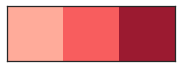

In [10]:
sns.palplot(greens)
sns.palplot(reds)

## Load Data

In [11]:
# DO NOT put data into github folders!

gdpath = os.path.expanduser('~/Google Drive/Bas Zahy Gianni - Games')
figdir = os.path.join(gdpath, 'Presentations/201702 Cosyne 2017/Figures')# 'Manuscripts/Cosyne2017Abstract/Figures') # for abstract

params_lrn = pd.read_csv(os.path.join(gdpath, 'Analysis/3_lrn/params_learn_final.csv'))
params_tai = pd.read_csv(os.path.join(gdpath, 'Analysis/5_tai/params_tai_final.csv'))

In [12]:
params_tai['condition'] = params_tai['condition'].map({0: 5, 1: 10, 2:20})

mean_correction_fields = [
    'elo', 'tree_size', 'attention', 'rt', 'lapse', 'act_scale', 'prune_thresh', 
    'value_quality', 'weight_center', 'weight_2conn', 'weight_2unc', 'weight_3', 'weight_4'
]

mean_correction_labels = ['mc ' + i for i in mean_correction_fields]

for i, p in enumerate([params_tai, params_lrn]):
    for val in mean_correction_fields:
        if val in p.columns:
            nv = 'mc ' + val
            mean_correction_labels.append(nv)
            mean_elos = p.pivot_table(index='subject', values=val)
            for i in p.subject.unique():
                p.loc[p.subject==i, nv] = p.loc[p.subject==i, val] - mean_elos[i]
            p[nv] = p[nv].fillna(method='ffill')
            
pl = params_lrn.groupby(['subject', 'session']).mean().reset_index()
pt = params_tai.groupby(['subject', 'condition']).mean().reset_index()

In [13]:
def get_corr_table(df, regressor_label):
    S = pd.DataFrame(index=mean_correction_labels, columns=['r', 'p'])
    for m in S.index:
        res = stats.linregress(df[regressor_label], df[m])
        S.loc[m, ['r', 'p']] = res.rvalue, res.pvalue
        
    return S

In [14]:
tai_corrs = dict()
for s in ['condition', 'mc rt', 'mc elo']:
    S = get_corr_table(params_tai, s)
    S.to_csv(os.path.join(gdpath, 'Analysis/5_tai/correlations/{}.csv'.format(s)))
    tai_corrs[s] = S

lrn_corrs = dict()
for s in ['session', 'mc elo', 'mc rt']:
    S = get_corr_table(params_lrn, s)
    S.to_csv(os.path.join(gdpath, 'Analysis/3_lrn/correlations/{}.csv'.format(s)))
    lrn_corrs[s] = S

# Final plots

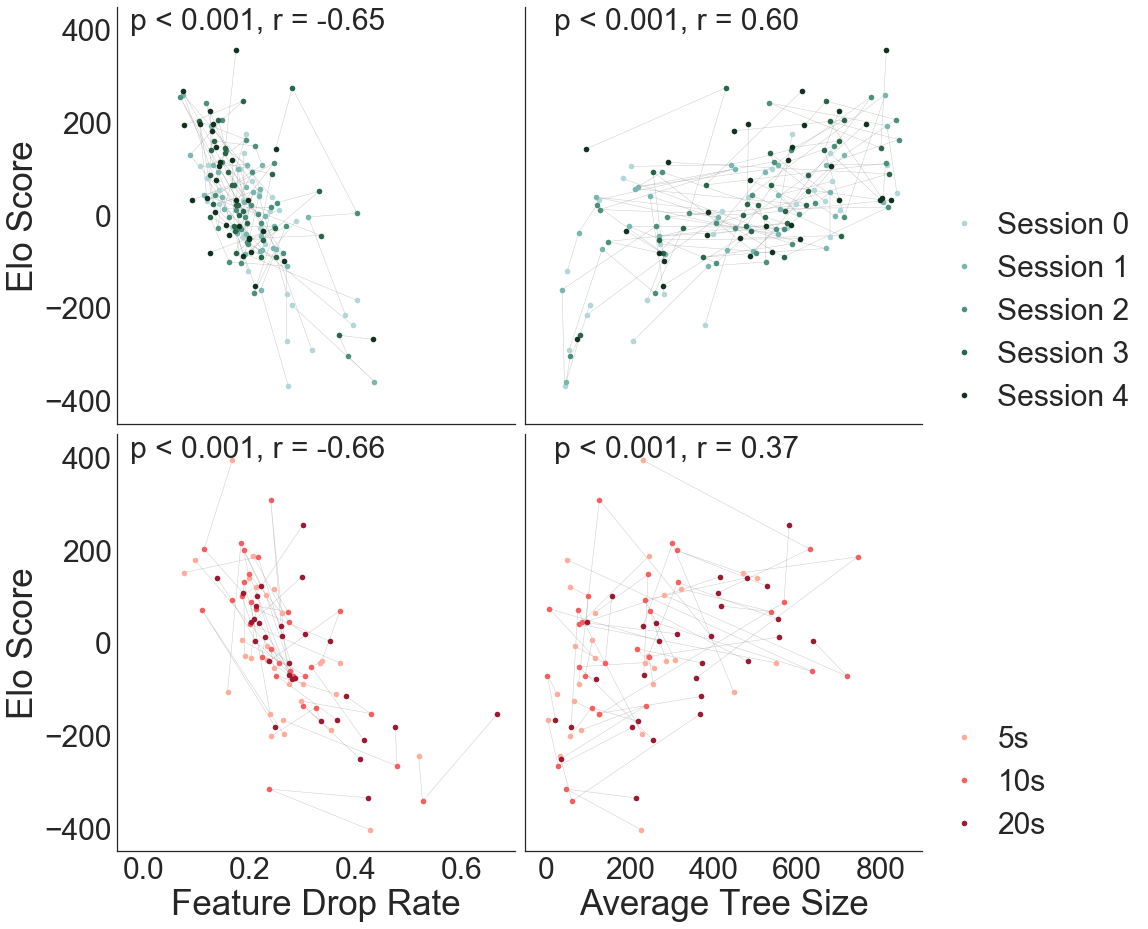

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(13, 13), sharey=True)
lineplotkws = {'linewidth': .5, 'alpha': .4, 'color': 'grey', 'label': 'none'}
scatterkws = {'linestyle': 'none', 'marker': 'o'}

divtypes = ['session', 'condition']
divlabels = ['Session {}', '{}s']
variables = ordict([('Feature Drop Rate', 'attention'), ('Tree Size', 'tree_size')])
legs = []

for e, experiment in enumerate([pl, pt]):
    for i, key in enumerate(variables.keys()):
        val = variables[key]
        ax = axes[e, i]
        div = divtypes[e]
        colors = [greens, reds][e]
        
        for j in experiment['subject'].unique():
            pdata = experiment.loc[experiment['subject']==j, :]
            ax.plot(pdata[val], pdata['elo'], **lineplotkws)
        
        for l, j in enumerate(experiment[div].unique()):
            pdata = experiment.loc[experiment[div]==j, :]
            c, la = colors[l], divlabels[e].format(j)
            ax.plot(pdata[val], pdata['elo'], color=c, label=la, **scatterkws)
            
        if i==1: 
            leg = ordict(zip(*ax.get_legend_handles_labels())).items()
            leg = ordict([(k, v) for k, v in leg if v != 'none'])
            leg = ax.legend(leg.keys(), leg.values(), loc=(1,0), handletextpad=0.1)
            legs.append(leg)
            
        res = stats.linregress(experiment[val], experiment['elo'])
        x = .05 if i == 0 else 20
        pvaltext = res.pvalue if res.pvalue > .0005 else .001
        textstring = 'p < {:.3f}, r = {:.2f}'.format(pvaltext, res.rvalue)
        ax.text(x-.075, 400, textstring, fontsize=30)

plt.setp(
    axes[:, 0],
    ylabel='Elo Score', ylim=[-450, 450], yticks=np.arange(-400, 500, 200),
    xlim=[-.05, .7], xticks=np.arange(0, .8, .2)
)

plt.setp(axes[:, 1], xlim=[-50, 900], xticks=np.arange(0, 1050, 200))
plt.setp(axes[0, :], xticks=[])
axes[1, 0].set_xlabel('Feature Drop Rate')
axes[1, 1].set_xlabel('Average Tree Size')

sns.despine()
plt.tight_layout()
fig.savefig(os.path.join(figdir, 'Elo vs Params.png'), bbox_extra_artists=legs, bbox_inches='tight')

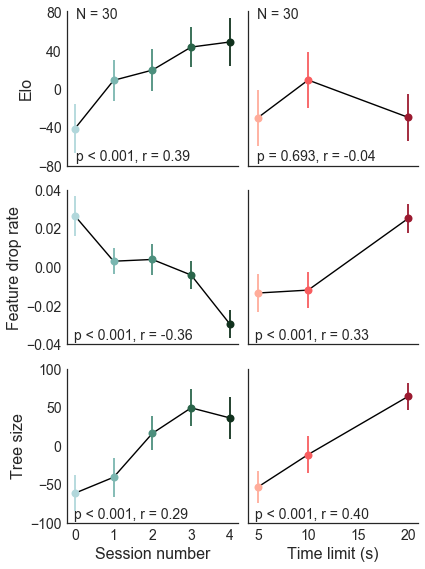

In [62]:
fig, axes = plt.subplots(3, 2, figsize=(6, 8))
variables = ordict([('Tree Size', 'mc tree_size'), ('Feature Drop Rate', 'mc attention')][::-1])

for a, exp in enumerate([pl, pt]):
    ax = axes[0, a]
    div = divtypes[a]
    p = exp.groupby(div).mean().reset_index()
    p_sem = exp.groupby(div).sem().reset_index()
    ax.plot(p[div], p['elo'], color='black')
    
    for j, s in enumerate(p[div].unique()):
        if j==0:
            s0 = s
        _p = p.loc[p[div]==s, :]
        ax.plot(
            _p[div], _p['elo'], 
            marker='o', markersize=8, linestyle='none', color=colorlist[a][j]
        )
        ax.errorbar(
            _p[div], _p['elo'], yerr=p_sem.loc[p_sem[div]==s, 'elo'], 
            color=colorlist[a][j], linewidth=1.8
        )
    
    res = stats.linregress(exp[div], exp['mc elo'])
    ax.text(.05, .95, "N = 30", fontsize=14, transform=ax.transAxes)
    ax.text(.05, .03, "p {} {:.3f}, r = {:.2f}".format(
            '=' if res.pvalue > .0005 else '<', 
            res.pvalue if res.pvalue > .0005 else .001, 
            res.rvalue), fontsize=14, transform=ax.transAxes
           )

plt.setp(axes[0, :], yticks=np.arange(-80, 81, 40))
plt.setp(axes[0, 0], xlim=[-.25, 4.25], xticks=[], xticklabels=[], ylabel='Elo')
plt.setp(axes[0, 1], xlim=[4, 21], xticks=[], xticklabels=[])

for a, exp in enumerate([pl, pt]):
    for i, k in enumerate(variables.keys()):
        v = variables[k]
        ax = axes[i+1, a]
        div = divtypes[a]
        colors = [greens, reds][a]
        
        p = exp.groupby(div).mean().reset_index()
        p_sem = exp.groupby(div).sem().reset_index()
        ax.plot(p[div], p[v], color='black')
        
        for l, c in enumerate(p[div].unique()):
            _p = p.loc[p[div]==c]
            
            ax.plot(
                _p[div], _p[v],
                color=colors[l], linestyle='none', marker='o', markersize=8,
                label='none'
            )

            ax.errorbar(
                _p[div], _p[v], yerr=p_sem.loc[p_sem[div]==c, v], linewidth=1.8, color=colors[l]
            )
            
        res = stats.linregress(exp[div], exp[v])
        ax.text(0.04, 0.03, 'p < {:.3f}, r = {:.2f}'.format(
                res.pvalue if res.pvalue > .0005 else .001, 
                res.rvalue), fontsize=14, transform=ax.transAxes)

plt.setp(axes[:, 0], xlim=[-.2, 4.2], xticks=np.arange(0, 4.1, 1))
plt.setp(axes[:, 1], xlim=[4, 21], xticks=np.arange(5, 21, 5), yticks=[])
plt.setp(axes[1, :], ylim=[-.04, .04], xticks=[])
plt.setp(axes[2, :], ylim=[-100, 100])

plt.setp(axes[1, 0], ylabel='Feature drop rate', yticks=np.arange(-.04, .041, .02))
plt.setp(axes[2, 0], ylabel="Tree size", xlabel='Session number', yticks=np.arange(-100, 101, 50))
plt.setp(axes[2, 1], xlabel='Time limit (s)')

sns.despine()
plt.tight_layout()
fig.savefig(os.path.join(figdir, 'Manip vs Params.png'))

/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


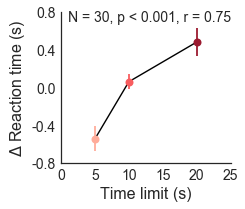

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(3.5, 3))

ptm = pt.groupby('condition').mean().reset_index()
ptsd = pt.groupby('condition').sem().reset_index()

axes.plot(ptm['condition'], ptm['mc rt'], color='black')

for e, i in enumerate(ptm.condition.unique()):
    p = ptm.loc[ptm['condition']==i, :]
    axes.plot(
        p['condition'], p['mc rt'],
        linestyle='none', marker='o', markersize=8, color=reds[e]
    )
    
    axes.errorbar(
        p['condition'], p['mc rt'], 
        yerr=2*ptsd.loc[ptsd['condition']==i, 'mc rt'], 
        color=reds[e], linewidth=1.8
    )
    
plt.setp(
    axes, 
    xlim=[0, 25], xticks=np.arange(0, 30, 5), xlabel='Time limit (s)',
    ylim=[-800, 800], yticks=np.arange(-800, 801, 400), yticklabels=np.arange(-.8, .81, .4),
    ylabel=r'$\Delta$'+' Reaction time (s)'
)

res = stats.linregress(pt['condition'], pt['mc rt'])

axes.text(1, 700, "N = 30, p < {:.3f}, r = {:.2f}".format(res.pvalue if res.pvalue > .0005 else .001, res.rvalue), fontsize=14)

plt.tight_layout()
sns.despine()
fig.savefig(os.path.join(figdir, 'Time limit vs RT.png'))

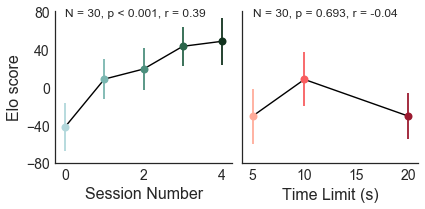

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

colorlist = [greens, reds]

for a, exp in enumerate([pl, pt]):
    ax = axes[a]
    div = divtypes[a]
    p = exp.groupby(div).mean().reset_index()
    p_sem = exp.groupby(div).sem().reset_index()
    ax.plot(p[div], p['elo'], color='black')
    
    for j, s in enumerate(p[div].unique()):
        if j==0:
            s0 = s
        _p = p.loc[p[div]==s, :]
        ax.plot(
            _p[div], _p['elo'], 
            marker='o', markersize=8, linestyle='none', color=colorlist[a][j]
        )
        ax.errorbar(
            _p[div], _p['elo'], yerr=p_sem.loc[p_sem[div]==s, 'elo'], 
            color=colorlist[a][j], linewidth=1.8
        )
    
    res = stats.linregress(exp[div], exp['mc elo'])
    ax.text(s0, 75, "N = 30, p {} {:.3f}, r = {:.2f}".format(
            '=' if res.pvalue > .0005 else '<', 
            res.pvalue if res.pvalue > .0005 else .001, 
            res.rvalue), fontsize=12
           )

    
plt.setp(axes, yticks=np.arange(-80, 81, 40))
plt.setp(axes[0], xlim=[-.25, 4.25], xlabel='Session Number', ylabel='Elo score')
plt.setp(axes[1], xlim=[4, 21], xticks=np.arange(5, 21, 5), xlabel='Time Limit (s)')


plt.tight_layout()
sns.despine()
fig.savefig(os.path.join(figdir, 'Elo against manip.png'))

p = 2.04581918994e-10 
r = -0.229435131591


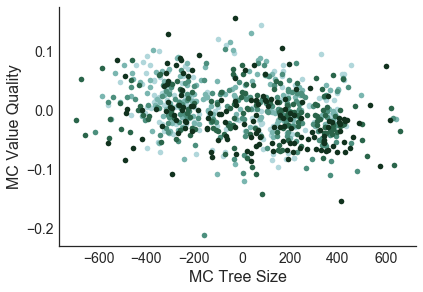

In [13]:
# for i in params_tai.subject.unique():
#     p = params_tai.loc[params_tai['subject']==i, :]
#     axes.plot(p['mc value_quality'], p['mc tree_size'], color='grey', alpha=.2)
fig, axes=plt.subplots(1,1)
for i in params_lrn['session'].unique():
    p = params_lrn.loc[params_lrn['session']==i, :]
    axes.plot(
        p['mc tree_size'], p['mc value_quality'], 
        linestyle='none', marker='o', 
#         label=['5 second', '10 second', '20 second'][i]
    )
    
plt.setp(axes, xlabel='MC Tree Size', ylabel='MC Value Quality')

linres = stats.linregress(params_lrn['mc tree_size'], params_lrn['mc value_quality'])
print(
    'p =', linres.pvalue, 
    '\nr =', linres.rvalue
)

sns.despine()

mc weight_center 
	p = 6.47601070333e-20 
	r = -0.325043820619
mc weight_2conn 
	p = 0.000279277985287 
	r = 0.132324413628
mc weight_2unc 
	p = 4.35650927885e-15 
	r = 0.281104027279
mc weight_3 
	p = 3.45497842897e-52 
	r = 0.515676357985
mc weight_4 
	p = 0.865411221241 
	r = -0.00619918093575


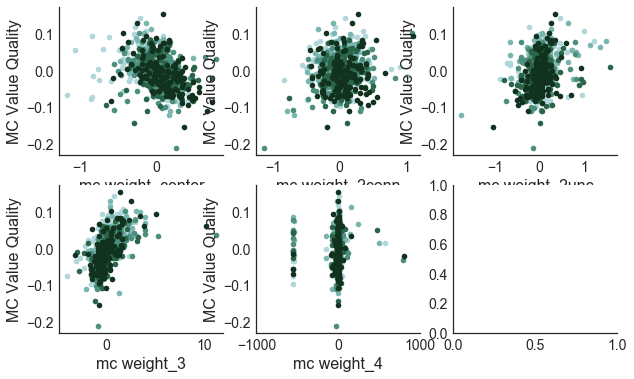

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for j, w in enumerate(['mc weight_center', 'mc weight_2conn', 'mc weight_2unc', 'mc weight_3', 'mc weight_4']):
    ax = axes.flatten()[j]
    for i in [0, 1, 2, 3, 4]:
        p = params_lrn.loc[params_lrn['session']==i, :]
        ax.plot(
            p[w], p['mc value_quality'], 
            linestyle='none', marker='o', 
    #         label=['5 second', '10 second', '20 second'][i]
        )
    
    plt.setp(ax, xlabel=w, ylabel='MC Value Quality')

    linres = stats.linregress(params_lrn[w], params_lrn['mc value_quality'])
    print(
        w,
        '\n\tp =', linres.pvalue, 
        '\n\tr =', linres.rvalue
    )

axes[1, 1].set_xlim([-1000, 1000])
    
# for i in params_tai.subject.unique():
#     p = params_tai.loc[params_tai['subject']==i, :]
#     axes.plot(p['mc value_quality'], p['mc tree_size'], color='grey', alpha=.2)
    
sns.despine()

# Params Timed AI

# Parameters Learning

In [7]:
L = pd.read_csv(os.path.join(gdpath, 'Data/3_lrn/Clean/_summaries/all_games_all_fields.csv'))
A = pd.read_csv(os.path.join(gdpath, 'Data/3_lrn/Clean/_summaries/all_afc2s_all_fields.csv'))

A['correct'] = 1
A.loc[(A.aval > A.bval) & (A.response == A.b), 'correct'] = 0
A.loc[(A.bval > A.aval) & (A.response == A.a), 'correct'] = 0
T = A.loc[A.aval != A.bval, :]

ranks = pd.read_csv(os.path.join(gdpath, 'Analysis/3_lrn/ratings_learn.csv'))
R = ranks.loc[ranks['Subject'] >= 0, :]
for s in R.Subject.unique():
    _r = R.loc[R.Subject == s, :]
    _g = _r.sort_values('Session').games.cumsum()
    
    R.loc[_g.index, 'games td'] = _g.values
R = R.sort_values(['Subject', 'Session'])

for s in R.Subject.unique():
    for ss in R.Session.unique():
        R.loc[(R.Subject==s)&(R.Session==ss), 'mean rt'] = L.loc[(L.subject==s)&(L.session==ss), 'rt'].mean()
        if ss%2 == 0:
            R.loc[(R.Subject==s)&(R.Session==ss), 'afc score'] = T.loc[(T.subject==s)&(T.session==ss), 'correct'].mean()

ratings = pd.read_csv(os.path.join(gdpath, 'Analysis/5_tai/ratings_tai (6).csv'))
ratings['Subject'] = ratings['Name'].map(lambda x: int(x[3:5]) if len(x) == 11 else np.nan)
ratings['condition'] = ratings['Name'].map(lambda x: int(x[-2:]) if len(x) == 11 else np.nan)
ratings = ratings.sort_values(['Subject', 'condition'])

/Users/gianni/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


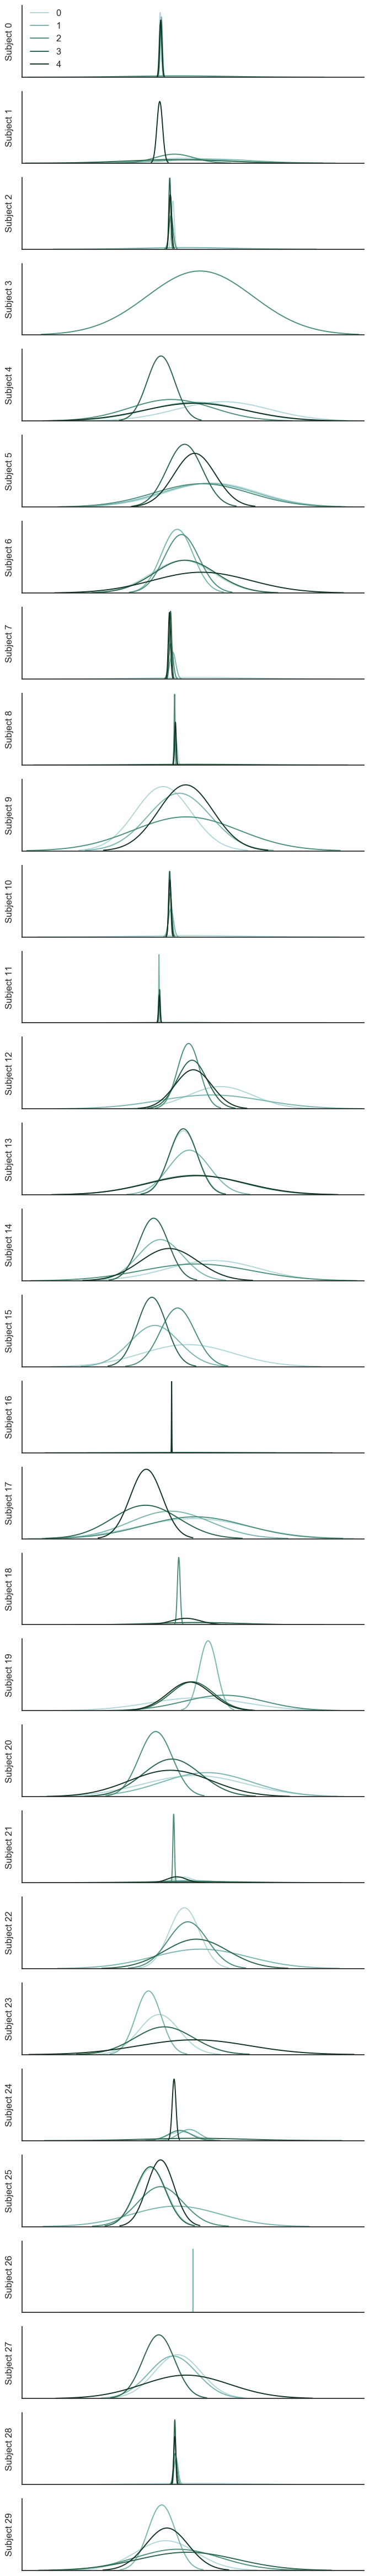

In [14]:
fig, axes = plt.subplots(params_lrn['subject'].unique().size, 1, figsize=(8, 60), squeeze=False)
for i in params_lrn['subject'].unique():
    for j in params_lrn['session'].unique():
        p = params_lrn.loc[(params_lrn['subject'] == i) & (params_lrn['session'] == j), :]
        mvs = stats.bayes_mvs(p['gamma'])
        mu = mvs[0][0]
        sig = mvs[2][0]
        x = np.arange(mu-3*sig, mu+3*sig, sig/10)
        axes[i, 0].plot(x, stats.norm(loc=mu, scale=sig).pdf(x), label=str(j))
    axes[i, 0].set_ylabel('Subject '+str(i))
        
axes[0, 0].legend(loc=0)
plt.setp(axes, xticklabels=[], yticklabels=[])
        
sns.despine()

# Timed Performance

# Learning Performance

In [12]:
stats.linregress(R['Session'], R['Elo'])

LinregressResult(slope=21.556666666666668, intercept=-27.193333333333335, rvalue=0.23752276608787709, pvalue=0.0034256190873668659, stderr=7.2466209532609236)

In [31]:
stats.linregress(np.log(d['mean rt']), d['afc score'])

LinregressResult(slope=0.04720868446624063, intercept=0.14254068102462686, rvalue=0.1789651649317763, pvalue=0.091462140981834708, stderr=0.02766580654699834)

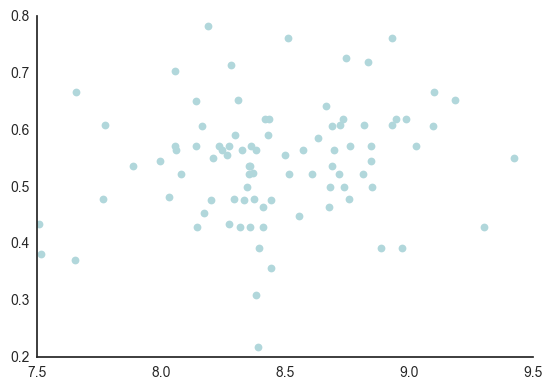

In [29]:
plt.plot(np.log(R['mean rt']), R['afc score'], linestyle='none', marker='o')
sns.despine()

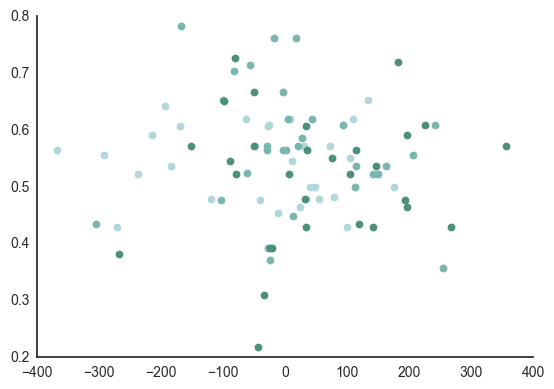

In [35]:
fig, axes = plt.subplots(1, 1)

d = R.loc[pd.notnull(R['afc score'])]
# for s in d.Subject.unique():
#     dd = d.loc[d.Subject==s, :]
#     axes.plot(dd['Elo'], dd['afc score'], color='grey')
    
for s in d.Session.unique():
    dd = d.loc[d.Session==s, :]
    axes.plot(dd['Elo'], dd['afc score'], marker='o', linestyle='none')
    
sns.despine()

0.540791224157
0.56991140673
0.514795922385
0.5407912241570413
0.5699114067304972
0.514795922385128


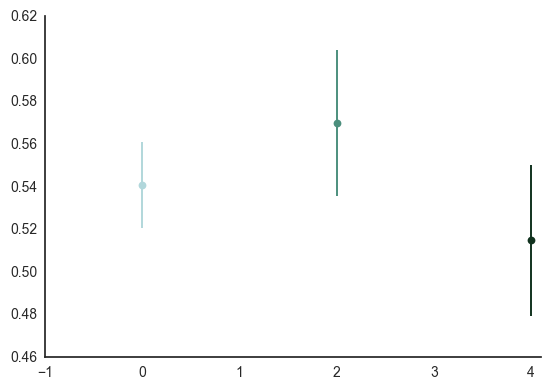

In [44]:
fig, axes = plt.subplots(1, 1)

for i in [0, 2, 4]:
    dd = d.loc[d.Session==i, 'afc score']
    mvs = stats.bayes_mvs(dd.values)
    print(mvs[0][0])
    axes.plot(i, mvs[0][0], marker='o', markerfacecolor=p[i])
    axes.errorbar(i, y=mvs[0][0], yerr=mvs[0][0]-mvs[0][1][0], color=p[i])
    
plt.setp(axes, xlim=[-1, 4.1])
sns.despine()

print(d.loc[d.Session==0, 'afc score'].mean())
print(d.loc[d.Session==2, 'afc score'].mean())
print(d.loc[d.Session==4, 'afc score'].mean())


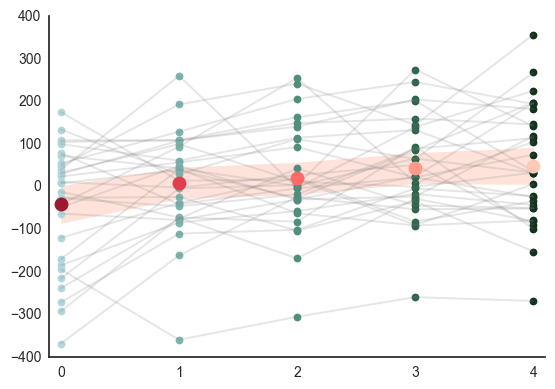

In [75]:
fig, axes = plt.subplots(1, 1)
mvs = []
for sess in np.arange(5):
    d = R.loc[R.Session == sess, :]
    mvs.append(stats.bayes_mvs(d['Elo']))
    axes.plot(d['Session'], d['Elo'], marker='o', linestyle='none', color=p.as_hex()[sess])
    axes.plot(sess, mvs[sess][0][0], color=p2.as_hex()[::-1][sess], marker='o', markersize=10, zorder=51)

axes.fill_between(
    x=[0, 1, 2, 3, 4], y1=[m[0][1][0] for m in mvs], y2=[m[0][1][1] for m in mvs],
    color=p2[0], alpha=.5
)
    
for sub in R.Subject.unique():
    d = R.loc[R.Subject == sub, :]
    axes.plot(d['Session'], d['Elo'], color='grey', alpha=.2)

sns.despine()

plt.setp(axes, xticks=np.arange(-1, 6, 1), xlim=[-.1, 4.1]);

In [164]:
mvs[0][1]

(-85.081425171970309, 2.0814251719702881)

LinregressResult(slope=0.020454933289512769, intercept=13.847233426662706, rvalue=0.0094500152913489857, pvalue=0.90862510554643661, stderr=0.17791612282026364)


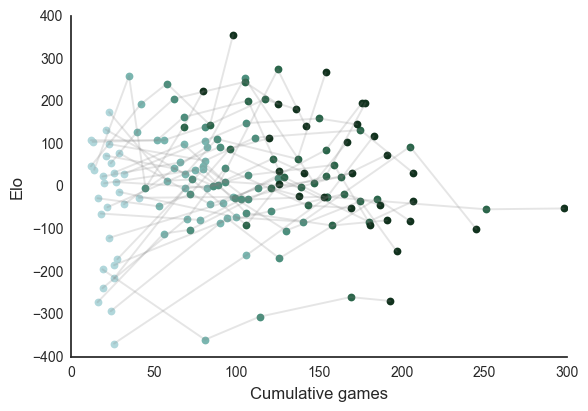

In [115]:
fig, axes = plt.subplots(1, 1)

for sess in np.arange(5):
    d = R.loc[R.Session == sess, :]
    axes.plot(d['games td'], d['Elo'], marker='o', linestyle='none')
for sub in R.Subject.unique():
    d = R.loc[R.Subject == sub, :]
    axes.plot(d['games td'], d['Elo'], color='grey', alpha=.2)
    
plt.setp(axes, xlabel='Cumulative games', ylabel='Elo')
sns.despine()

print(stats.linregress(R['games td'], R['Elo']))

(Mean(statistic=90.433333333333337, minmax=(36.739652745507321, 144.12701392115935)), Variance(statistic=22208.420987654314, minmax=(13114.553573170651, 37366.778067045416)), Std_dev(statistic=147.6517209916087, minmax=(114.5187913539549, 193.30488371235072)))
LinregressResult(slope=-0.24088205960760156, intercept=131.03801918118805, rvalue=-0.072806849135339372, pvalue=0.70220705762636881, stderr=0.62358991061094893)


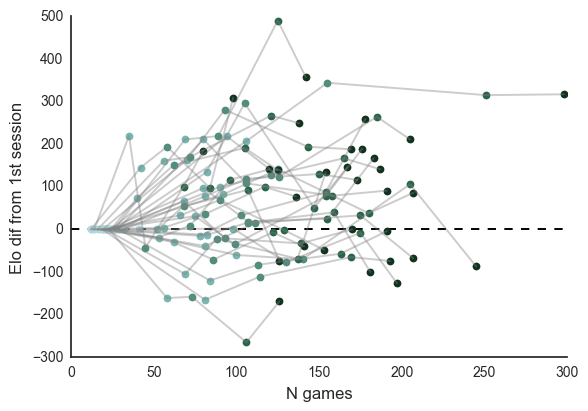

In [138]:
fig, axes = plt.subplots(1, 1)

for s in R.Subject.unique():
    R.loc[R.Subject == s, 'first elo'] = R.loc[R.Subject == s, 'Elo'].values[0]
R['elo dif'] = R['Elo'] - R['first elo']
E = R.copy() #R.loc[R.Session == 4, :]
e = E.loc[E.Session==4, :]
print(stats.bayes_mvs(e['elo dif'].values, alpha=.95))
print(stats.linregress(e['games td'], e['elo dif']))

axes.plot((0, 300), (0, 0), color='black', linestyle='--')

for s in np.arange(5):
    e = E.loc[E.Session==s]
    axes.plot(e['games td'], e['elo dif'], linestyle='none', marker='o')
for s in E.Subject.unique():
    e = E.loc[E.Subject==s]
    axes.plot(e['games td'], e['elo dif'], color='grey', alpha=.4)
    

sns.despine()
plt.setp(axes, xlabel='N games', ylabel='Elo dif from 1st session');

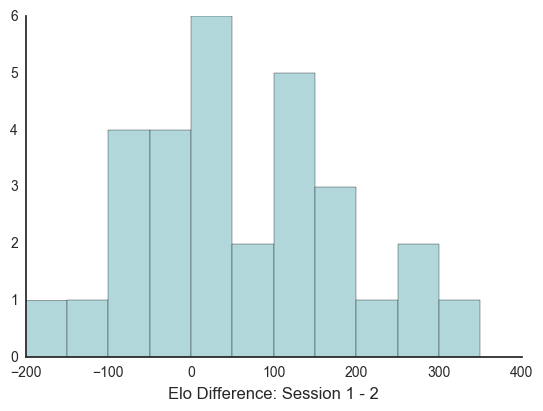

In [98]:
plt.hist(E.values, bins = np.arange(-200, 400, 50))
plt.xlabel('Elo Difference: Session 1 - 2')
sns.despine()

LinregressResult(slope=0.0020352945299456863, intercept=80.630793288200337, rvalue=0.023285242663161853, pvalue=0.90279167989006626, stderr=0.016513902334489707)


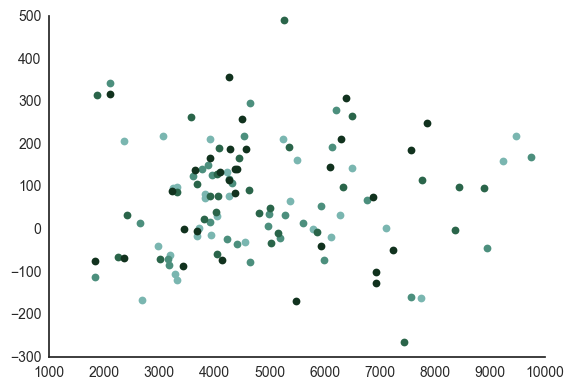

In [239]:
fig, axes = plt.subplots(1, 1)

for sess in np.arange(1, 5, 1):
    t = R.loc[R.Session == sess]
    plt.plot(t['mean rt'], t['elo dif'], marker='o', linestyle='none', color=p[sess])
sns.despine()
print(stats.linregress(t['mean rt'], t['elo dif']))

LinregressResult(slope=-116.54065570860232, intercept=5198.4806448593308, rvalue=-0.0861625109328822, pvalue=0.29445701966374127, stderr=110.76693603932858)

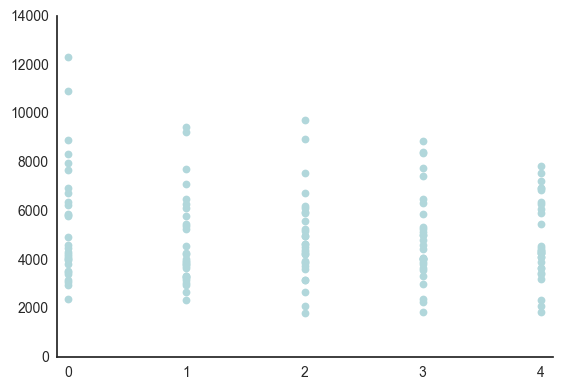

In [244]:
fig, axes = plt.subplots(1, 1)

axes.plot(R['Session'], R['mean rt'], marker='o', linestyle='none')
plt.setp(axes, xlim=[-.1, 4.1])
sns.despine()

stats.linregress(R['Session'], R['mean rt'])

# opening moves